# Connecting to UniBit Api

Importing Libraries

In [1]:
import requests
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import statistics

In [2]:
API_KEY = ## get your free API key

Functions definition

In [3]:
def getIntraDayByTicker(Ticker):
    """ This function takes as an input ticker symbole
    and returns intraday stock price as an object"""
    import requests
    import json
    response = requests.get('https://api.unibit.ai/realtimestock/'+Ticker+'?AccessKey='+API_KEY)
    data_str = response.text
    parsed_data = json.loads(data_str)
    return parsed_data    

In [4]:
def getStockNewsByTicker(Ticker):
    """ This function takes as an input ticker symbole
    and returns Latest stock news data array"""
    import requests
    import json
    response = requests.get('https://api.unibit.ai/news/latest/'+Ticker+'?AccessKey='+API_KEY)
    data_str = response.text
    parsed_data = json.loads(data_str)
    return parsed_data    

In [5]:
def getHistoricalPrice(Ticker,rng,interval):
    """ This function takes as an input ticker symbole, range as rng and interval
    and returns historical stock price as object
    Possible ranges : 1m - 3m - 1y - 3y - 5y - 10y - 20y
    A positive number (n). If passed, chart data will return every nth element as defined by Interval"""
    import requests
    import json
    response = requests.get('https://api.unibit.ai/historicalstockprice/'+Ticker+'?range='+rng+'&interval='+str(interval)+'&AccessKey='+API_KEY)
    data_str = response.text
    parsed_data = json.loads(data_str)
    return parsed_data    

Creating the dataframe of intraday price

In [6]:
AAPL_intra = pd.DataFrame(data = getIntraDayByTicker("AAPL"))

In [7]:
AAPL_intra.head(2)

,date,minute,price,ticker
0,20190321,15:25,196.03,AAPL
1,20190321,15:22,196.04,AAPL


Adding time index, the combination of date and time and setting it as an index

In [8]:
AAPL_intra["time_index"] = pd.to_datetime((AAPL_intra['date'] + AAPL_intra["minute"]).values, format='%Y%m%d%H:%M')
AAPL_intra.set_index("time_index",inplace=True)

## Visualizing intraday stock price

We see that the data isn't consistent between 16 February until 01 March

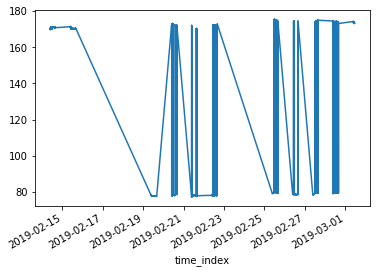

In [9]:
AAPL_intra.tail(4000).price.plot()

Creating dataframe of historical stock price

In [10]:
AAPL_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='AAPL',rng="3y",interval=1)["Stock price"])

Setting the date as an index

In [11]:
AAPL_hist.date = pd.to_datetime(AAPL_hist.date)
AAPL_hist.set_index("date",inplace=True)

## Visualzing historical stock close price

The plot seems accepatable comparable to the intraday plot

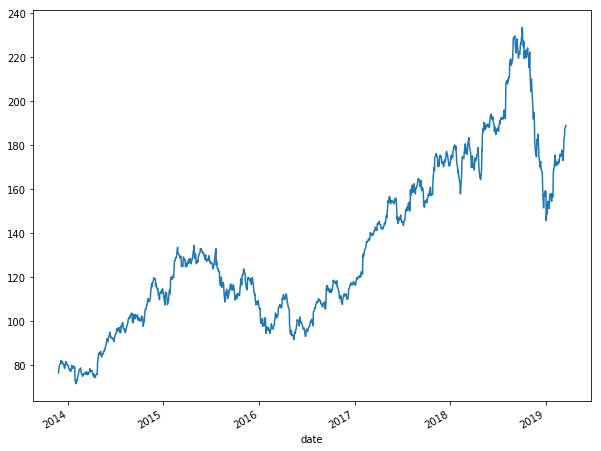

In [12]:
AAPL_hist.close.plot(figsize=[10,8])

We will continue with the historical data to do some predictions using multiple models

# EDA

In [13]:
AAPL_hist.describe()

,adj_close,close,high,low,open,volume
count,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1.335000e+03
mean,126.500204,132.829221,131.720478,130.546658,131.688388,4.321852e+07
std,39.851096,38.053175,37.704124,37.346266,37.702191,2.405375e+07
min,60.505500,71.647100,71.397100,70.507100,70.740000,1.147590e+07
25%,96.558750,103.140000,102.580000,101.560000,102.630000,2.651850e+07
50%,114.733000,121.220000,120.070000,119.610000,120.420000,3.666000e+07
75%,156.837500,161.550000,159.930000,158.725000,160.105000,5.277725e+07
max,230.275000,233.470000,232.070000,229.780000,230.780000,2.663808e+08


AAPL stock price and volume evolution

[None, None, None, None, None, None, None, None, None, None, None, None]

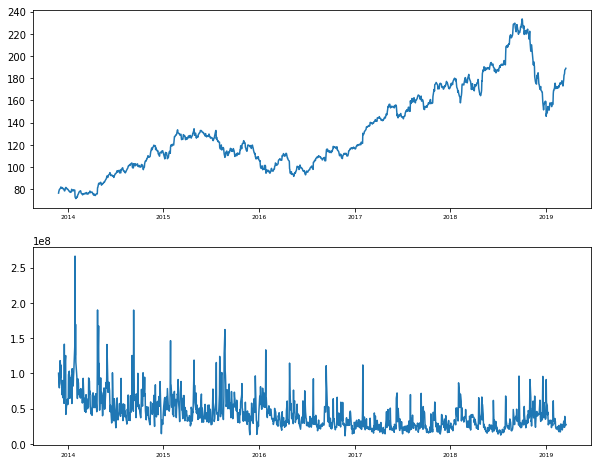

In [14]:
plt.figure(figsize=[10,8])
ax1 = plt.subplot(211)
plt.plot(AAPL_hist.close)
plt.setp(ax1.get_xticklabels(), fontsize=6)
ax2 = plt.subplot(212)
plt.plot(AAPL_hist.volume)
plt.setp(ax2.get_xticklabels(), fontsize=6)

### In this part we will look for anomalies in both volume and price

##### Support Vector Machine-Based Anomaly Detection

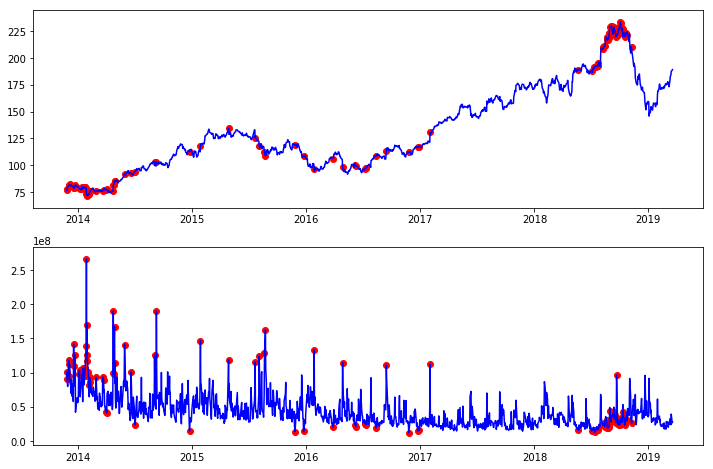

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

data = AAPL_hist[['close', 'volume']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
outliers_fraction =0.09
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
AAPL_hist['anomaly'] = pd.Series(model.predict(data),index=AAPL_hist.index)

fig, ax = plt.subplots(figsize=(12,8))
a = AAPL_hist.loc[AAPL_hist['anomaly'] == -1, ['close','volume']] #anomaly
ax = plt.subplot(212)
ax.plot( AAPL_hist['volume'], color='blue')
ax.scatter(a.index,a['volume'], color='red')
ax1 = plt.subplot(211)
ax1.plot( AAPL_hist['close'], color='blue')
ax1.scatter(a.index,a['close'], color='red')
plt.show();

# Feature engenieering

#### First type of Features

We create a window moving average

In [16]:
def pastNdayCloseMean(variable,N):
    """This function returns past N day moving average serie
    N is number of days
    variable is Dataframe or series to apply the function EX: AAPL_hist.close"""
    pastNdaysCloseMean = []
    for ind in range(0,variable.count()):
        pastNdaysCloseMean.append(variable.head(ind+N).tail(N).mean())
    return pastNdaysCloseMean

We will create a weekley window and a monthly window for the close, Meaning 7 days and 30 days

In [17]:
AAPL_hist["weekely_close_window_mean"] = pd.Series(pastNdayCloseMean(AAPL_hist.close,7),index=AAPL_hist.index)
AAPL_hist["monthly_close_window_mean"] = pd.Series(pastNdayCloseMean(AAPL_hist.close,30),index=AAPL_hist.index)

We will create a weekley window and a monthly window for the volume, Meaning 7 days and 30 days

In [18]:
AAPL_hist["weekely_volume_window_mean"] = pd.Series(pastNdayCloseMean(AAPL_hist.volume,7),index=AAPL_hist.index)
AAPL_hist["monthly_volume_window_mean"] = pd.Series(pastNdayCloseMean(AAPL_hist.volume,30),index=AAPL_hist.index)

#### Second Feature

We create the feature indicating duration between current value and last anomalie detected

In [19]:
def lastAnomaly(variable):
    """This function returns serie of last anomalie detected
    variable is Dataframe or series to apply the function EX: AAPL_hist"""
    lastAnomaly = variable.anomaly.copy().values
    firstAnomalyIndex = np.where(lastAnomaly==-1)[0][0]
    last=0
    for ind,value in enumerate(lastAnomaly):
        if(value==-1):
            last=0
            lastAnomaly[ind]=last
        else:
            last=last+1
            lastAnomaly[ind]=last
    maxAnomaly = lastAnomaly[firstAnomalyIndex:].max()
    for ind,value in enumerate(lastAnomaly[:firstAnomalyIndex]):
        lastAnomaly[ind]=maxAnomaly-firstAnomalyIndex+ind
    return lastAnomaly

In [20]:
AAPL_hist["lastAnomaly_AAPL"] = pd.Series(lastAnomaly(AAPL_hist),index=AAPL_hist.index)

We can see the UP and Downs of the last anomaly 

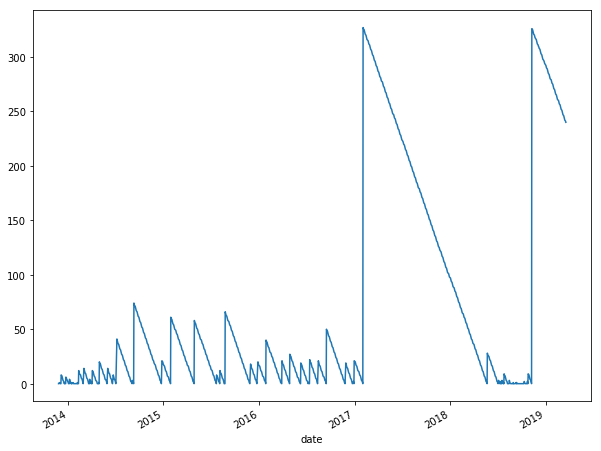

In [21]:
AAPL_hist.lastAnomaly_AAPL.plot(figsize=(10,8))

### Related data

We can add other features which related domain companies. In AAPL case, we can use [ AMZN, FB, GOOG, MSFT, TSLA ] and aggregate their data to be added to our dataset

We will focus only on Close and volume

In [22]:
AMZN_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='AMZN',rng="3y",interval=1)["Stock price"])
FB_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='FB',rng="3y",interval=1)["Stock price"])
GOOG_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='GOOG',rng="3y",interval=1)["Stock price"])
#MSFT_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='MSFT',rng="3y",interval=1)["Stock price"])
#TSLA_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='TSLA',rng="3y",interval=1)["Stock price"])
#Internal server error on microsoft and tesla data

Setting the time index

In [23]:
AMZN_hist.date = pd.to_datetime(AMZN_hist.date)
AMZN_hist.set_index("date",inplace=True)
FB_hist.date = pd.to_datetime(FB_hist.date)
FB_hist.set_index("date",inplace=True)
GOOG_hist.date = pd.to_datetime(GOOG_hist.date)
GOOG_hist.set_index("date",inplace=True)

##### After a little search I found top 10 Major Companies Tied to the Apple Supply Chain like "Analog Devices, Inc (ADI)", "Glu Mobile, Inc. (GLUU)", "Jabil Circuit Inc. (JBL)", "STMicroelectronics (STM)" ... 

We can add some of those companies stock to our model

In [24]:
ADI_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='ADI',rng="3y",interval=1)["Stock price"])
GLUU_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='GLUU',rng="3y",interval=1)["Stock price"])
JBL_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='JBL',rng="3y",interval=1)["Stock price"])
#STM_hist = pd.DataFrame(data = getHistoricalPrice(Ticker='STM',rng="3y",interval=1)["Stock price"])

Setting Time Index

In [25]:
ADI_hist.date = pd.to_datetime(ADI_hist.date)
ADI_hist.set_index("date",inplace=True)
GLUU_hist.date = pd.to_datetime(GLUU_hist.date)
GLUU_hist.set_index("date",inplace=True)
JBL_hist.date = pd.to_datetime(JBL_hist.date)
JBL_hist.set_index("date",inplace=True)

We will create two more features, One for related field companies and the Other for the tied to the apple supply chain

##### Related field dataframe

In [26]:
Related_field = pd.merge(AMZN_hist[['close','volume']],FB_hist[['close','volume']],how='left',on='date',suffixes=('_AMZN','_FB'))
Related_field = pd.merge(Related_field,GOOG_hist[['close','volume']],how='left',on='date',suffixes=('','_GOOG'))

##### Tied to supply chain

In [27]:
Supply_chain = pd.merge(ADI_hist[['close','volume']],GLUU_hist[['close','volume']],how='left',on='date',suffixes=('_ADI','_GLUU'))
Supply_chain = pd.merge(Supply_chain,JBL_hist[['close','volume']],how='left',on='date',suffixes=('','_JBL'))

Scaling Values for volume and close

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(Related_field.fillna(0))
Related_field_fit = scaler.transform(Related_field.fillna(0))

scaler.fit(Supply_chain.fillna(0))
Supply_chain_fit = scaler.transform(Supply_chain.fillna(0))

In [29]:
Related_field = pd.DataFrame(Related_field_fit,index=Related_field.index,columns=Related_field.columns)
Supply_chain = pd.DataFrame(Supply_chain_fit,index=Supply_chain.index,columns=Supply_chain.columns)

Now extract the mean of each

In [30]:
Related_field["Related_field_close_mean"] = Related_field[["close_AMZN","close_FB","close"]].mean(axis=1)
Related_field["Related_field_volume_mean"] = Related_field[["volume_AMZN","volume_FB","volume"]].mean(axis=1)

In [31]:
Supply_chain["Supply_chain_close_mean"] = Supply_chain[["close_ADI","close_GLUU","close"]].mean(axis=1)
Supply_chain["Supply_chain_volume_mean"] = Supply_chain[["volume_ADI","volume_GLUU","volume"]].mean(axis=1)

#### Now we merge all data to AAPL_hist dataframe

In [32]:
AAPL_hist["Related_field_close_mean"] = Related_field["Related_field_close_mean"]
AAPL_hist["Related_field_volume_mean"] =Related_field["Related_field_volume_mean"]
AAPL_hist["Supply_chain_close_mean"] = Supply_chain["Supply_chain_close_mean"]
AAPL_hist["Supply_chain_volume_mean"] = Supply_chain["Supply_chain_volume_mean"]

Standardizing AAPL features

In [35]:
scaler = StandardScaler()
scaler.fit(AAPL_hist[['adj_close', 'close', 'high', 'low', 'open', 'volume','weekely_close_window_mean','monthly_close_window_mean','weekely_volume_window_mean','monthly_volume_window_mean']])
AAPL_hist_fit = scaler.transform(AAPL_hist[['adj_close', 'close', 'high', 'low', 'open', 'volume','weekely_close_window_mean','monthly_close_window_mean','weekely_volume_window_mean','monthly_volume_window_mean']])
AAPL_hist[['adj_close', 'close', 'high', 'low', 'open', 'volume','weekely_close_window_mean','monthly_close_window_mean','weekely_volume_window_mean','monthly_volume_window_mean']] = AAPL_hist_fit

Filling missing values

In [36]:
AAPL_hist.isnull().sum(axis = 0)

adj_close                     0
close                         0
high                          0
low                           0
open                          0
volume                        0
anomaly                       0
weekely_close_window_mean     0
monthly_close_window_mean     0
weekely_volume_window_mean    0
monthly_volume_window_mean    0
lastAnomaly_AAPL              0
Related_field_close_mean      3
Related_field_volume_mean     3
Supply_chain_close_mean       3
Supply_chain_volume_mean      3
dtype: int64

In [37]:
AAPL_hist.fillna(0,inplace=True)

In [38]:
AAPL_hist.drop(['anomaly'],axis=1,inplace=True)

In [39]:
AAPL_hist.to_csv("clean_Stock_data.csv",index=True)

In [40]:
AAPL_hist.to_csv("clean_Stock_data_no_index.csv",index=False)

# Model building

Rearranging columns

In [41]:
cols = AAPL_hist.columns.tolist()
type(cols)
cols.remove('close')
cols.append('close')
AAPL_hist = AAPL_hist[cols]

## We will use a RNNs with basic, LSTM, GRU cells

### First method

In [42]:
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [43]:
# load the dataset
dataframe = pd.read_csv('clean_Stock_data_no_index.csv', engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [44]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

892 440


In [45]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :dataset.shape[1]-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, dataset.shape[1]-1])
    return numpy.array(dataX), numpy.array(dataY)

In [46]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [47]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], dataset.shape[1]-1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], dataset.shape[1]-1, testX.shape[1]))

In [48]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(dataset.shape[1]-1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 7s - loss: 0.2791
Epoch 2/100
 - 6s - loss: 0.2764
Epoch 3/100
 - 6s - loss: 0.2731
Epoch 4/100
 - 8s - loss: 0.2684
Epoch 5/100
 - 7s - loss: 0.2639
Epoch 6/100
 - 6s - loss: 0.2597
Epoch 7/100
 - 6s - loss: 0.2561
Epoch 8/100
 - 6s - loss: 0.2519
Epoch 9/100
 - 7s - loss: 0.2498
Epoch 10/100
 - 8s - loss: 0.2450
Epoch 11/100
 - 8s - loss: 0.2420
Epoch 12/100
 - 6s - loss: 0.2391
Epoch 13/100
 - 7s - loss: 0.2372
Epoch 14/100
 - 7s - loss: 0.2368
Epoch 15/100
 - 6s - loss: 0.2362
Epoch 16/100
 - 6s - loss: 0.2346
Epoch 17/100
 - 6s - loss: 0.2324
Epoch 18/100
 - 6s - loss: 0.2323
Epoch 19/100
 - 6s - loss: 0.2347
Epoch 20/100
 - 6s - loss: 0.2326
Epoch 21/100
 - 6s - loss: 0.2317
Epoch 22/100
 - 6s - loss: 0.2493
Epoch 23/100
 - 6s - loss: 0.2308
Epoch 24/100
 - 7s - loss: 0.2316
Epoch 25/100
 - 6s - loss: 0.2316
Epoch 26/100
 - 6s - loss: 0.2310
Epoch 27/100
 - 6s - loss: 0.2304
Epoch 28/100
 - 7s - loss: 0.2295
Epoch 29/100
 - 7s - loss: 0.2297
Epoch 30/100
 - 7s - lo

In [49]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.46 RMSE
Test Score: 0.70 RMSE


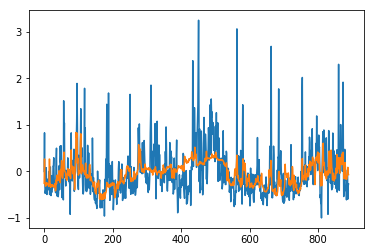

In [50]:
plt.plot(trainY)
plt.plot(trainPredict)

### Second Method

In [51]:
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [52]:
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [53]:
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(AAPL_hist, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1051, 19, 15)
y_train.shape =  (1051, 15)
x_valid.shape =  (132, 19, 15)
y_valid.shape =  (132, 15)
x_test.shape =  (132, 19, 15)
y_test.shape =  (132, 15)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [54]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = len(AAPL_hist.columns) 
n_neurons = 200 
n_outputs = len(AAPL_hist.columns) 
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 924.753357/60.628922
5.00 epochs: MSE train/valid = 16.248083/4.127186
9.99 epochs: MSE train/valid = 15.219675/4.040225
14.99 epochs: MSE train/valid = 21.390024/4.137837
19.98 epochs: MSE train/valid = 18.072943/4.334026
24.98 epochs: MSE train/valid = 29.360153/4.593444
29.97 epochs: MSE train/valid = 15.637210/4.010762
34.97 epochs: MSE train/valid = 29.508242/4.639712
39.96 epochs: MSE train/valid = 14.486982/4.363230
44.96 epochs: MSE train/valid = 14.685497/4.513310
49.95 epochs: MSE train/valid = 17.776358/4.398561
54.95 epochs: MSE train/valid = 15.397426/4.616565
59.94 epochs: MSE train/valid = 14.949018/4.703108
64.94 epochs: MSE train/valid = 16.759302/5.597197
69.93 epochs: MSE train/valid = 14.358047/5.407842
74.93 epochs: MSE train/valid = 13.502975/5.693261
79.92 epochs: MSE train/valid = 15.369617/6.239914


correct sign prediction for close - open price for train/valid/test: 0.49/0.80/0.26


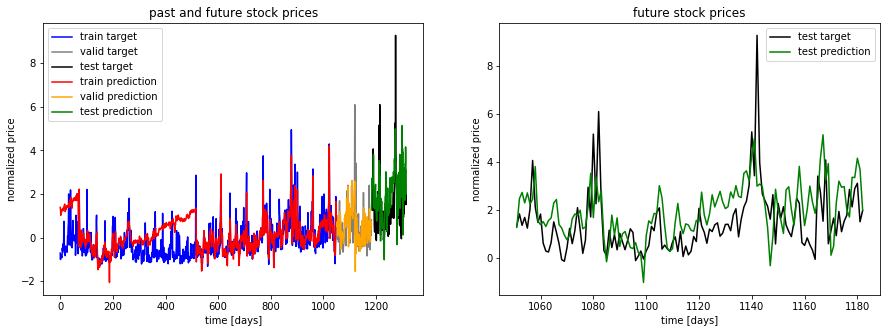

In [74]:
ft = 4 # 0 to 14 including all variables

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))